In [1]:
import math
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset into dataframe
df_exo = pd.read_csv('Starsystem_data.csv')

In [3]:
# Print ou column names
print(df_exo.columns)

Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2

In [4]:
# Function to calculate planetary density
def calculate_planetary_density(mass, radius):
    if radius <= 0:
        return np.nan  # Return NaN for zero or negative radius
    volume = (4.0/3.0) * math.pi * radius**3
    density = mass / volume
    return density if density < 1e30 else np.nan  # Check for extremely large values

# Apply the function to calculate density
df_exo['pl_density'] = df_exo.apply(lambda row: calculate_planetary_density(row['pl_bmasse'], row['pl_rade']), axis=1)

# Replace infinities with NaN
df_exo.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define Earth's characteristics for comparison
earth_features = {
    'pl_rade': 1,  # Earth radius
    'pl_bmasse': 1,  # Earth mass
    'pl_orbper': 365.25,  # Earth orbital period
    'pl_eqt': 255,  # Approximate Earth equilibrium temperature
    'pl_orbeccen': 0.0167,  # Earth's orbital eccentricity
    'pl_insol': 1,  # Earth's insolation flux
    'st_teff': 5778,  # Sun's effective temperature in Kelvin
    'st_rad': 1,  # Sun's radius
    'st_mass': 1,  # Sun's mass
    'st_met': 0,  # Sun's metallicity
    'pl_orbsmax': 1,  # Earth's semimajor axis
    'pl_density': 5.51  # Earth's density (g/cm^3)
}

# Update features for the model
features = list(earth_features.keys())

# Calculate similarity score
def calculate_similarity(row):
    score = 0
    for feature in earth_features:
        score += abs(row[feature] - earth_features[feature])
    return score

# Apply the similarity function to the dataset
df_exo['similarity_score'] = df_exo.apply(calculate_similarity, axis=1)


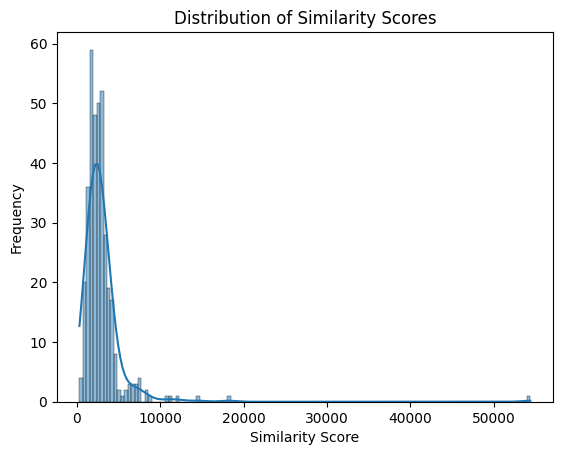

In [5]:
# Plot the distribution of similarity scores
sns.histplot(df_exo['similarity_score'], kde=True)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Check for missing values in the 'similarity_score' column
missing_values = df_exo['similarity_score'].isna().sum()
print(f"Number of missing values in 'similarity_score': {missing_values}")

# Remove rows with missing similarity scores
df_exo = df_exo.dropna(subset=['similarity_score'])

# Calculate percentiles for the cleaned data
for percentile in [50, 75, 90, 95, 99]:
    value = np.percentile(df_exo['similarity_score'], percentile)
    print(f"{percentile}th percentile: {value}")

Number of missing values in 'similarity_score': 34747
50th percentile: 2474.018879395826
75th percentile: 3274.047683670167
90th percentile: 4380.42709576208
95th percentile: 6406.215808287836
99th percentile: 11680.15415796896


In [7]:
# Label planets as Earth-like based on a threshold
threshold = 6406
df_exo['is_earth_like'] = df_exo['similarity_score'] <= threshold

# Prepare data for the model
features = list(earth_features.keys())
X = df_exo[features]
y = df_exo['is_earth_like']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

<ipython-input-7-5ae30a37eba6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exo['is_earth_like'] = df_exo['similarity_score'] <= threshold


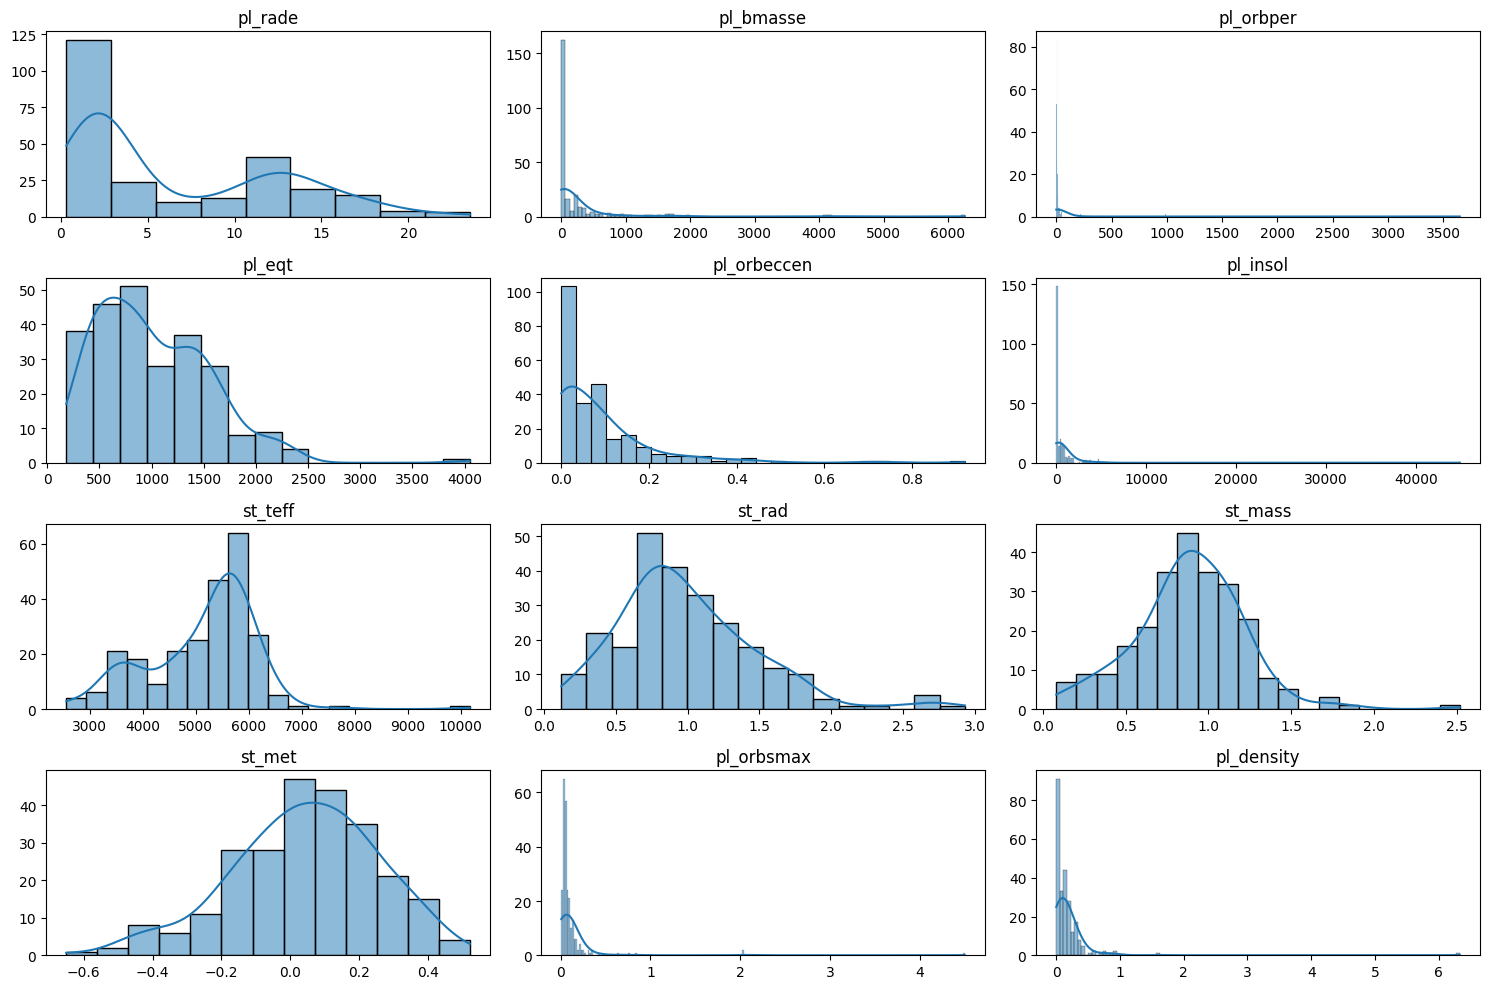

In [8]:
# Sample a subset of the data for visualization
df_sample = df_exo.sample(n=250, random_state=42)

# Number of rows and columns for the subplots
n_rows = 4
n_cols = 3

# Create a figure for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(earth_features):
    sns.histplot(df_sample[feature], kde=True, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Adjust the layout
plt.tight_layout()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Model
model = Sequential()
model.add(Dense(32, input_dim=len(features), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

# Implement early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
10/10 [==============================] - 2s 56ms/step - loss: 0.6771 - accuracy: 0.6259 - val_loss: 0.6221 - val_accuracy: 0.9459
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.3879 - accuracy: 0.9456 - val_loss: 0.4940 - val_accuracy: 0.9459
Epoch 3/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.2843 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 12ms/step - loss: 0.2609 - accuracy: 0.9490 - val_loss: 0.4031 - val_accuracy: 0.9459
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1789 - accuracy: 0.9558 - val_loss: 0.3428 - val_accuracy: 0.9459
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 0.1435 - accuracy: 0.9558 - val_loss: 0.2960 - val_accuracy: 0.9459
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.1089 - accuracy: 0.9660 - val_loss: 0.2600 - val_accuracy: 0.9730
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0876 - accuracy: 0.9796 - val_loss: 0.2248 - val_accuracy: 0.9730
Epoch 8/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0669 - accuracy: 0.9830 - val_loss: 0.1919 - val_accuracy: 0.9730
Epoch 9/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0592 - accuracy: 0.9796 - val_loss: 0.1614 - val_accuracy: 0.9730
Epoch 10/50
10/10 [=====

In [12]:
# Predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5)  # Convert probabilities to binary output

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print(classification_report(y_test, predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

3/3 [==============================] - 0s 5ms/step
Accuracy: 0.97
              precision    recall  f1-score   support

       False       1.00      0.50      0.67         4
        True       0.97      1.00      0.99        70

    accuracy                           0.97        74
   macro avg       0.99      0.75      0.83        74
weighted avg       0.97      0.97      0.97        74



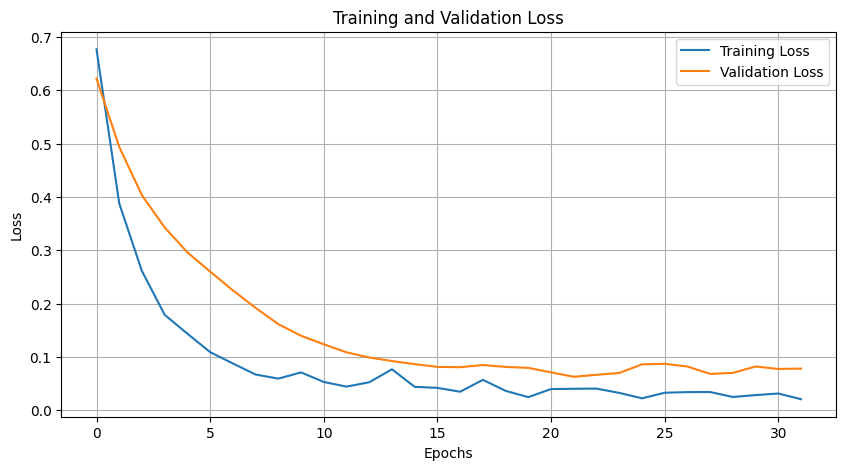

In [14]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save or display the plot
plt.savefig('loss_plot.png')  # Save the plot as an image
plt.show()  # Display the plot

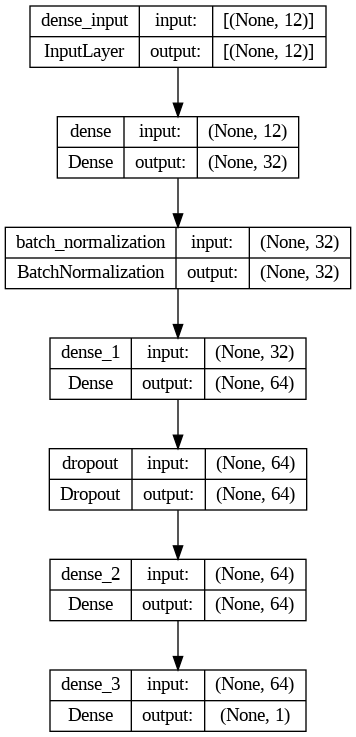

In [16]:
# Visualization of model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)